In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from getdist import plots, MCSamples, loadMCSamples
import classy as Class
import getdist
import pickle as pkl

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

dirname = "/Users/gabe/projects/emulators/data/modrec/chains"
sample_path = os.path.join(dirname, "modrec")
s = loadMCSamples(sample_path, settings={'ignore_rows': 0.5})

In [82]:
def find_index_of(array, values):
    indices_return = []
    for value in values:
        test = np.where(array<value, 1, 0)
        ind = np.argwhere(np.diff(test)!=0)[0][0]
        indices_return.append(ind)
    return indices_return

######################################################
# Loading best fit values for LCDM run and computing
######################################################

dirname = "/Users/gabe/projects/cobaya/data/lcdm_baseline_fixed_connect/chains"
sample_path = os.path.join(dirname, "lcdm_baseline_fixed_connect")
ll_max = 4000 #maximum \ell we will consider
lcdm_sample = loadMCSamples(sample_path, settings={'ignore_rows': 0.25})
lcdm_bestfit = lcdm_sample.getParamBestFitDict()
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none',
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

param_dict = {'H0': lcdm_bestfit["H0"],
              'omega_b': lcdm_bestfit["omega_b"],
              'omega_cdm': lcdm_bestfit["omega_cdm"],
              'ln10^{10}A_s': lcdm_bestfit["logA"],
              'n_s': lcdm_bestfit["n_s"],
              'tau_reio': lcdm_bestfit["tau_reio"]
              }

common_settings.update(param_dict)

M = Class.Class()
M.set(common_settings)
M.compute()

######################################################
# Computing fiducial thermodynamics
######################################################

thermo = M.get_thermodynamics()

cutoff_redshifts = [200, 2500]

cutoffs = find_index_of(thermo["z"], cutoff_redshifts)
z = thermo['z'][cutoffs[0]:cutoffs[1]]
xe_fid = thermo['x_e'][cutoffs[0]:cutoffs[1]]
viz = thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"]
gz_fid = viz[cutoffs[0]:cutoffs[1]]

Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2

######################################################
# Computing fiducial spectra
######################################################

tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]


In [5]:
modrec = s.getParams().__dict__
H0_high_bounds = [72, 73]
high_H0_ind = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>H0_high_bounds[0], modrec["H0"]<H0_high_bounds[1]))).flatten()

H0_low_bounds = [66.813, 67.813]
low_H0_ind = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>H0_low_bounds[0], modrec["H0"]<H0_low_bounds[1]))).flatten()
low_H0_ind = low_H0_ind[::150]

In [6]:
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control',
                   'xe_pert_num': 7,
                   'zmin_pert': 800,
                   'zmax_pert': 1400,
                   'xe_control_pivots': "800.0000,900.0000,1000.0000,1100.0000,1200.0000,1300.0000,1400.0000",
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

M = Class.Class()
M.set(common_settings)

tt_high_dict = {}
te_high_dict = {}
ee_high_dict = {}

for i in high_H0_ind:
    cp_string = "0.0,{},{},{},{},{},0.0".format(modrec["q_1"][i], modrec["q_2"][i], modrec["q_3"][i], modrec["q_4"][i], modrec["q_5"][i])
    param_dict = {'H0': modrec["H0"][i],
                'omega_b': modrec["omega_b"][i],
                'omega_cdm': modrec["omega_cdm"][i],
                'ln10^{10}A_s': modrec["logA"][i],
                'n_s': modrec["n_s"][i],
                'tau_reio': modrec["tau_reio"][i],
                "xe_control_points": cp_string
                }
    M.set(param_dict)
    M.compute()
    Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
    muK2 = (Tcmb)**2
    tt = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
    te = muK2*M.lensed_cl(ll_max)['te'][2:]
    ee = muK2*M.lensed_cl(ll_max)['ee'][2:]
    tt_high_dict[i] = tt
    te_high_dict[i] = te
    ee_high_dict[i] = ee

tt_low_dict = {}
te_low_dict = {}
ee_low_dict = {}

for i in low_H0_ind:
    cp_string = "0.0,{},{},{},{},{},0.0".format(modrec["q_1"][i], modrec["q_2"][i], modrec["q_3"][i], modrec["q_4"][i], modrec["q_5"][i])
    param_dict = {'H0': modrec["H0"][i],
                'omega_b': modrec["omega_b"][i],
                'omega_cdm': modrec["omega_cdm"][i],
                'ln10^{10}A_s': modrec["logA"][i],
                'n_s': modrec["n_s"][i],
                'tau_reio': modrec["tau_reio"][i],
                "xe_control_points": cp_string
                }
    M.set(param_dict)
    M.compute()
    Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
    muK2 = (Tcmb)**2
    tt = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
    te = muK2*M.lensed_cl(ll_max)['te'][2:]
    ee = muK2*M.lensed_cl(ll_max)['ee'][2:]
    tt_low_dict[i] = tt
    te_low_dict[i] = te
    ee_low_dict[i] = ee


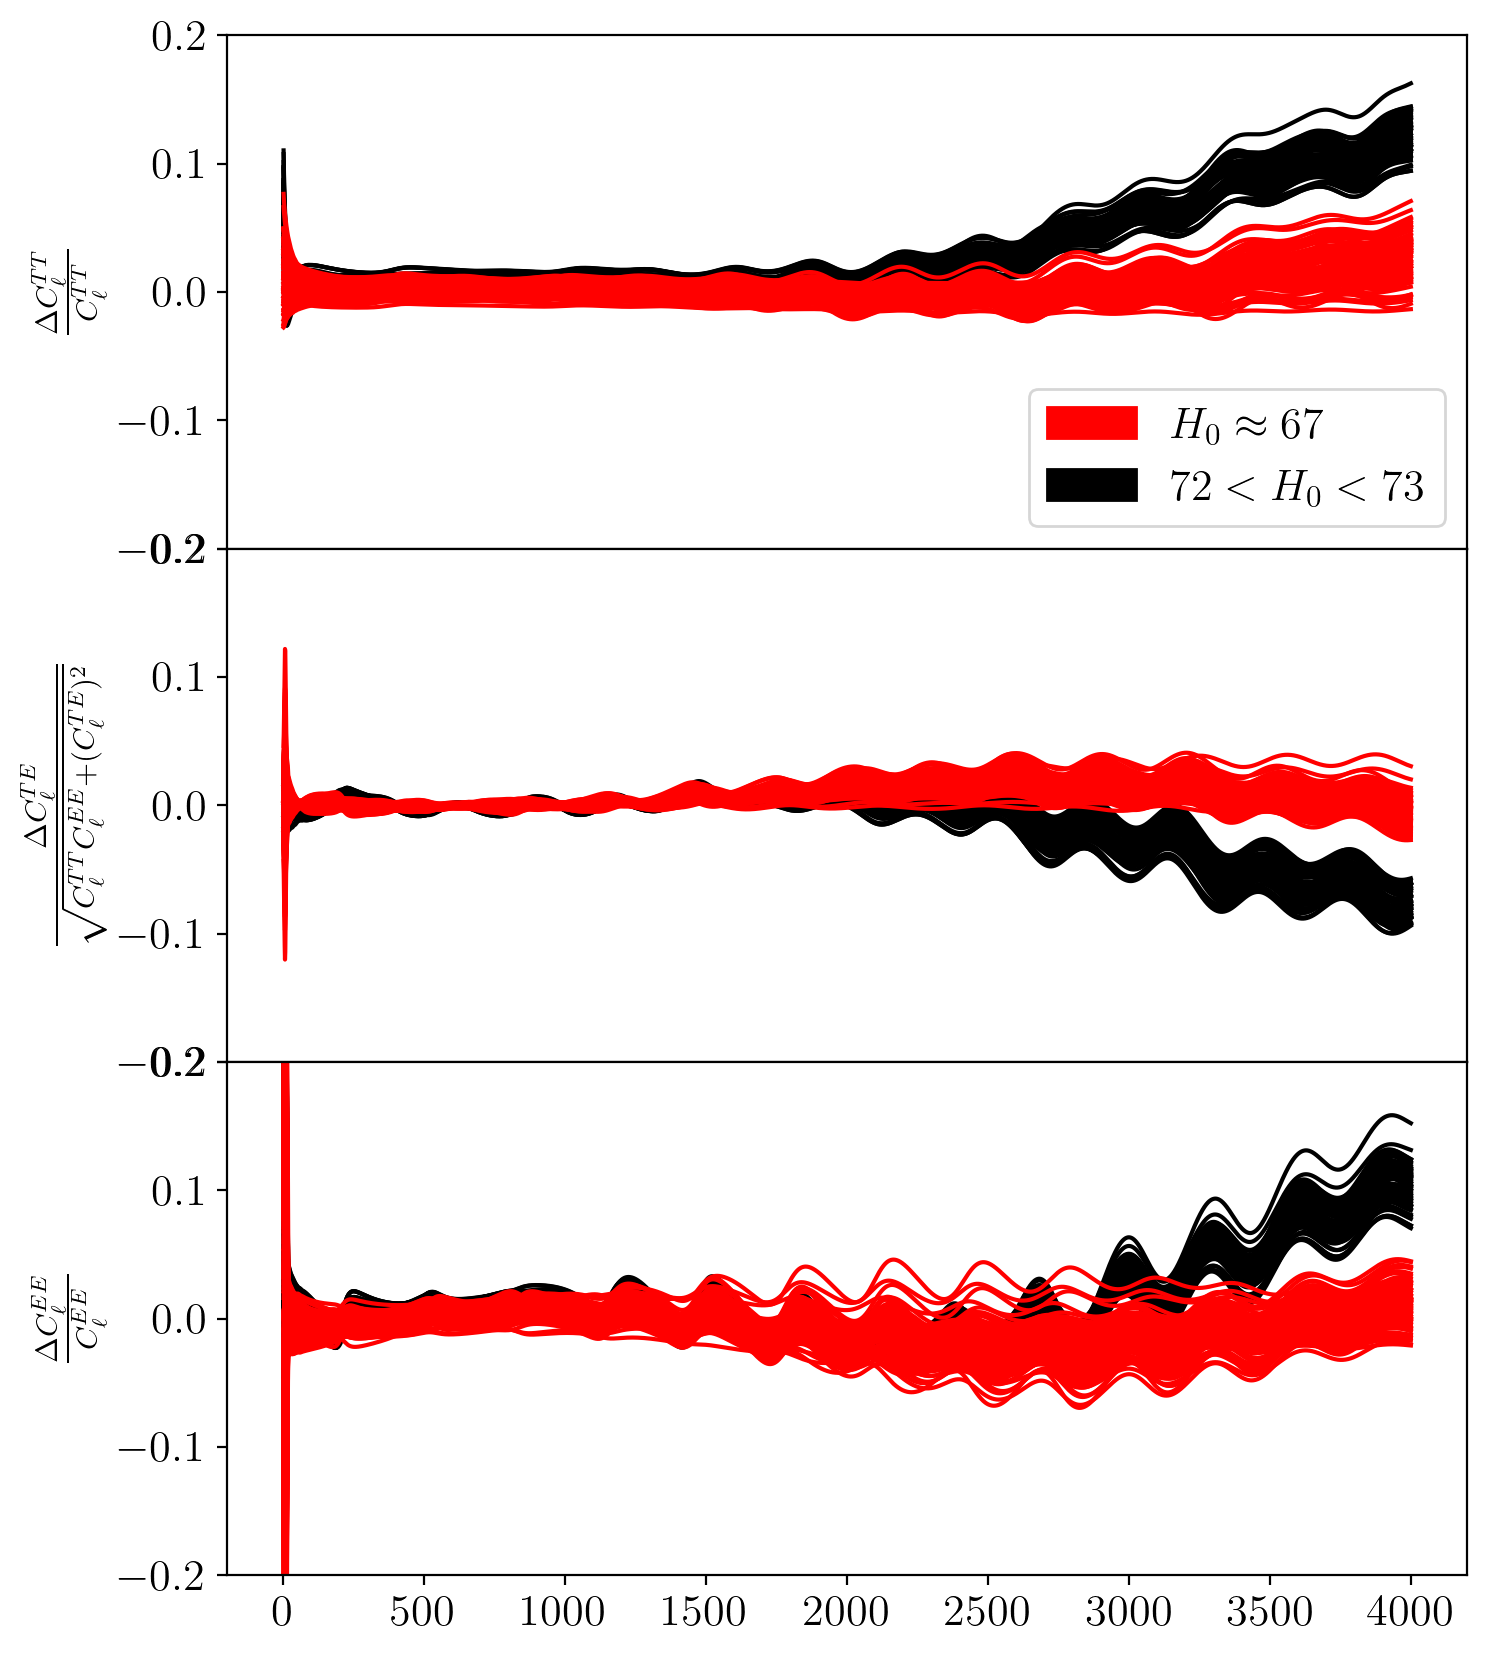

In [7]:
import matplotlib.patches as mpatches

fig,ax = plt.subplots(3,1, figsize=(8,10), sharex=True)
plt.subplots_adjust(hspace=0.0)

for i in high_H0_ind:
    ax[0].plot(ll, (tt_high_dict[i]-tt_fid)/(tt_fid), color="black")
    ax[0].set_ylabel("$\\frac{\Delta C_\ell^{TT}}{C_\ell^{TT}}$")
    ax[1].plot(ll, (te_high_dict[i]-te_fid)/(np.sqrt(tt_fid*ee_fid+te_fid**2)), color="black")
    ax[1].set_ylabel("$\\frac{\Delta C_\ell^{TE}}{\sqrt{C_\ell^{TT} C_\ell^{EE} + (C_\ell^{TE})^2}}$")
    ax[2].plot(ll, (ee_high_dict[i]-ee_fid)/(ee_fid), color="black")
    ax[2].set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")
for i in low_H0_ind:
    ax[0].plot(ll, (tt_low_dict[i]-tt_fid)/tt_fid, color="red")
    #ax[0].set_ylabel("$D^TT_\ell - D^TT_{\ell, \\text{fid}}$")
    ax[1].plot(ll, (te_low_dict[i]-te_fid)/np.sqrt(tt_fid*ee_fid+te_fid**2), color="red")
    #ax[1].set_ylabel("$D^TE_\ell - D^TE_{\ell, \\text{fid}}$")
    ax[2].plot(ll, (ee_low_dict[i]-ee_fid)/ee_fid, color="red")
    #ax[2].set_ylabel("$D^EE_\ell - D^EE_{\ell, \\text{fid}}$")

patch68 = mpatches.Patch(color='red', label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color='black', label='$72 < H_0 < 73$')
ax[0].legend(handles=[patch68, patch95], loc="lower right")

ylims = [-0.2,0.2]

for a in ax:
    a.set_ylim(ylims)

plt.show()

## Comparison with SPT-3G errors

In [18]:
######################################################
# get_noise function from Karthik
######################################################

def get_noise(w_half, ll, lknee=300, aknee=1):
    return (1 + (lknee/ll)**aknee) * np.deg2rad(w_half/60)**2

######################################################
# 3G beam files from Karthik. Columns are:
# ell bl_(90) bl_(150) bl_(220)
######################################################

bl_ll, bl_90, bl_150, bl_220 = np.loadtxt("../data/compiled_2020_beams.txt", skiprows=2, unpack=True, max_rows=ll_max-1)

######################################################
# 3G noise levels (w^-1/2) for EE, from Karthik
# Given units are uK-arcmin, so the divison by 60
# is to convert to degrees before then converting to 
# radians. The final unit is thus uK^2 after squaring
######################################################

w_90 = 1.414*3
w_150 = 1.414*2.2
w_220 = 1.414*8.8

A_combined = np.sqrt(1.0/(1./(w_90**2/bl_90**2) + 1./(w_150**2/bl_150**2) + 1./(w_220**2/bl_220**2)))
ilc_Nl = get_noise(A_combined, ll)


f_sky = 0.037

error_bar_3G = np.sqrt(2/(f_sky*(2*ll+1)))*(ee_fid + ilc_Nl)
print(error_bar_3G)


[1.04997957e-01 5.62678497e-02 2.54993879e-02 ... 9.13570495e-08
 9.13554536e-08 9.13539152e-08]


(0.0, 4000.0)

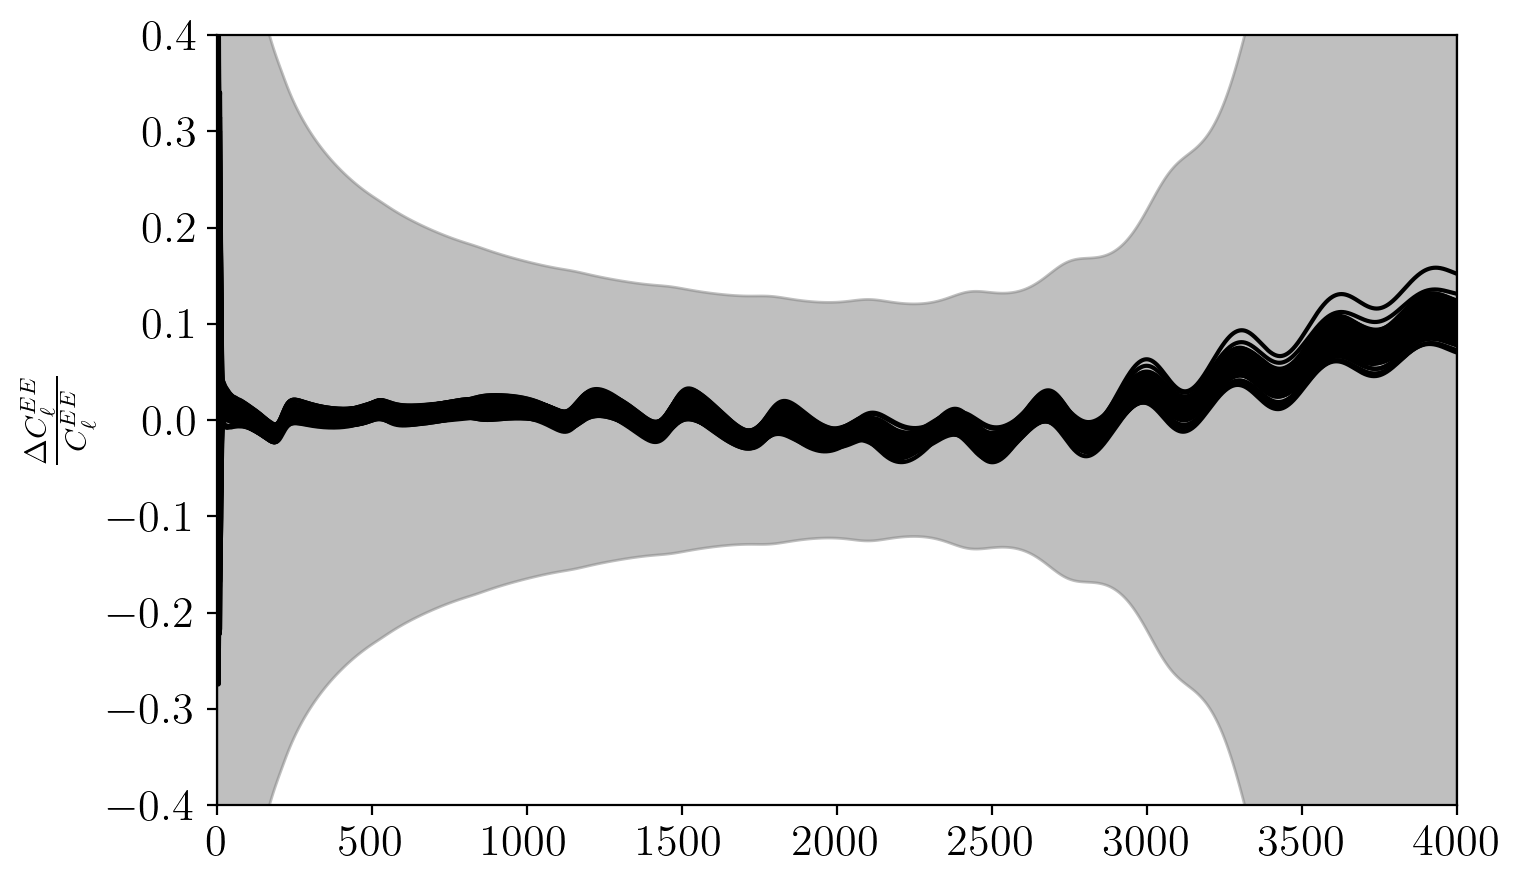

In [31]:
fig,ax = plt.subplots(figsize=(8,5))

ref_model=ee_fid

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ref_model, color="black")
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")
   #ax.set_ylabel("$\Delta C_\ell^{EE}$")

#for i in low_H0_ind:
#    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ref_model, color="red")

ax.fill_between(ll, -error_bar_3G/ref_model/1, error_bar_3G/ref_model/1, alpha=0.5, color="gray")


patch68 = mpatches.Patch(color='red', label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color='black', label='$72 < H_0 < 73$')
#ax.legend(handles=[patch68, patch95], loc="lower right")

#ax.set_ylim([-5e-8, 5e-8])
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([0, 4000])


#plt.show()
#plt.savefig("../results/ee_residuals_3G_error.png",dpi=300, bbox_inches='tight')

In [62]:
high_H0_color = "cornflowerblue"
low_H0_color = "firebrick"

(75.0, 4000.0)

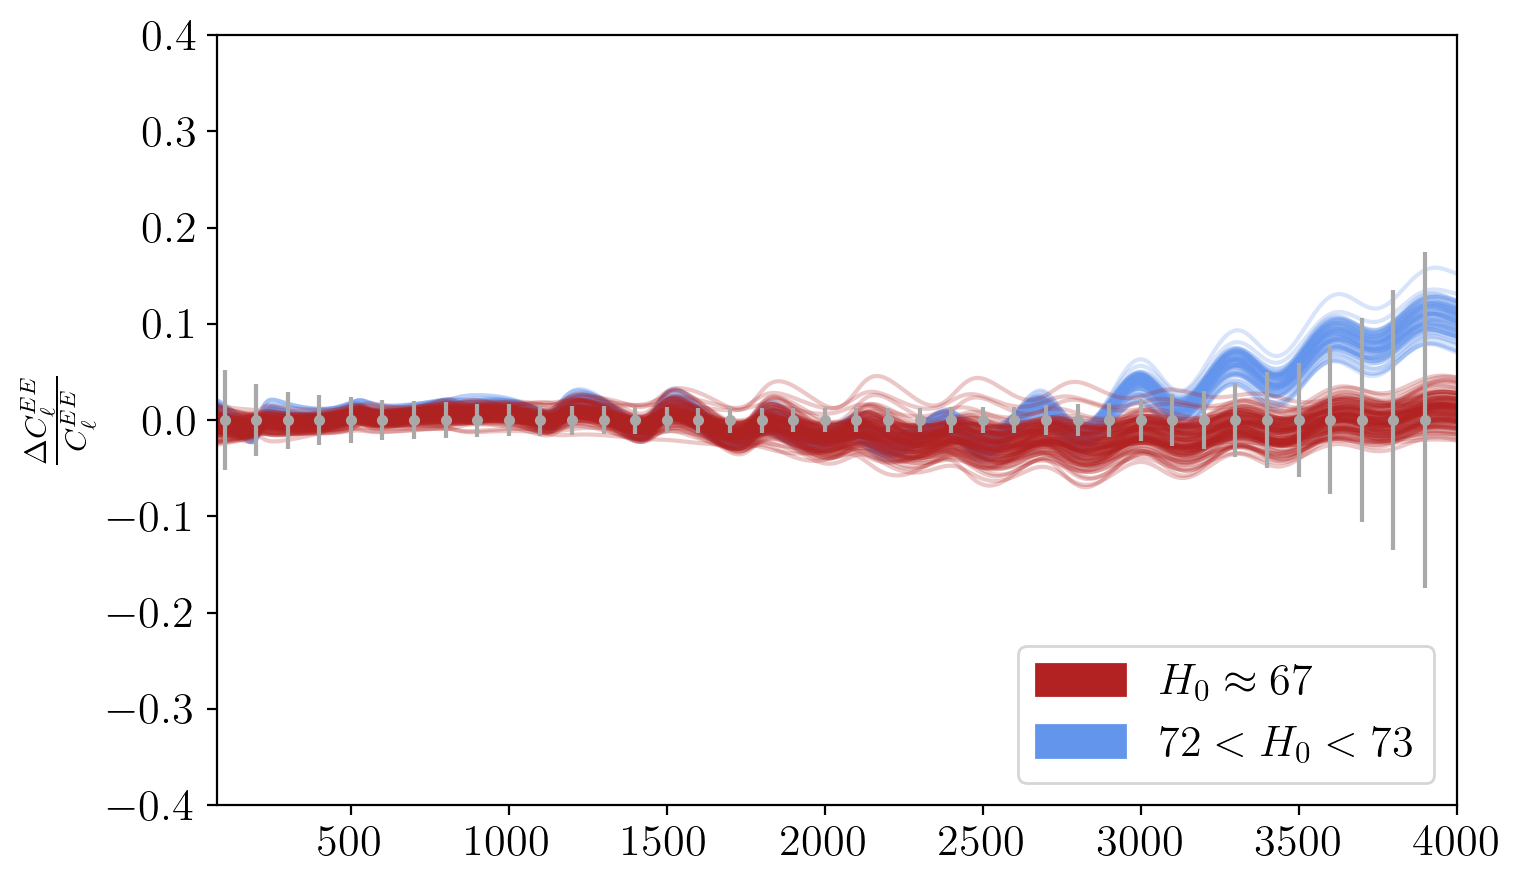

In [80]:
fig,ax = plt.subplots(figsize=(8,5))

ref_model=ee_fid

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ref_model, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")
   #ax.set_ylabel("$\Delta C_\ell^{EE}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ref_model, color=low_H0_color, alpha=0.25)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G[x_values-2]/ref_model[x_values-1]/10, fmt=".", color="darkgray")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

#ax.set_ylim([-5e-8, 5e-8])
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([75, 4000])



(75.0, 4000.0)

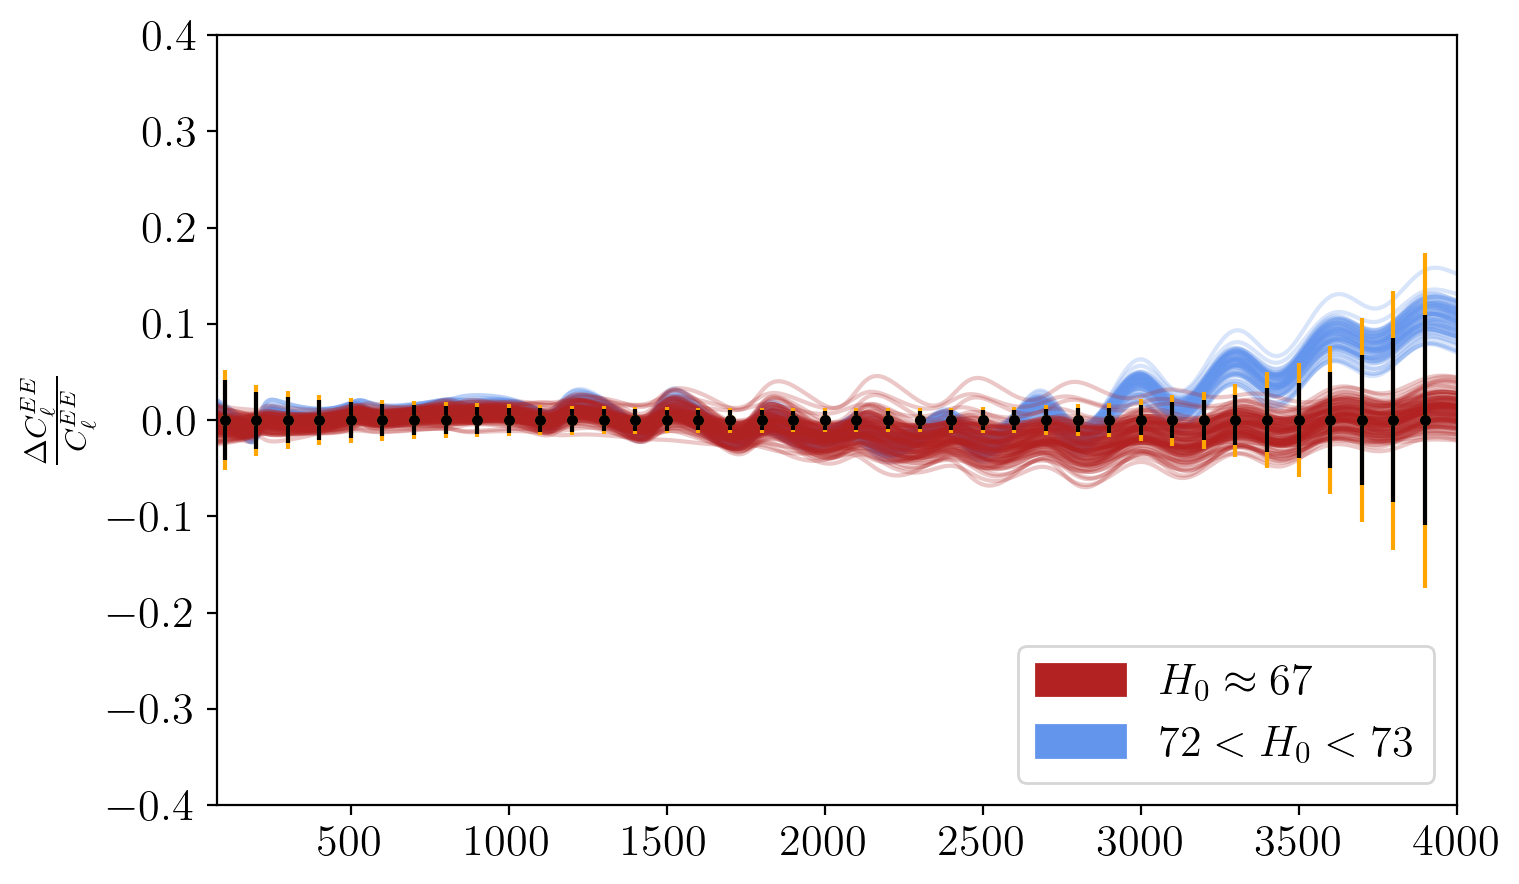

In [81]:
fig,ax = plt.subplots(figsize=(8,5))

ref_model=ee_fid

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ref_model, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")
   #ax.set_ylabel("$\Delta C_\ell^{EE}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ref_model, color=low_H0_color, alpha=0.25)

tobs = 1
field = 100 #square degrees
skyarea = 41252.96125
fsky_smallfield = field/skyarea
ilc_Nl_smallfield = ilc_Nl*(6/tobs)*(field/1500)
error_bar_3G_smallfield = np.sqrt(2/(fsky_smallfield*(2*ll+1)))*(ee_fid + ilc_Nl_smallfield)

error_bar_3G_combined = 1.0/(1.0/error_bar_3G + 1.0/error_bar_3G_smallfield)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G[x_values-2]/ref_model[x_values-2]/10, fmt=".", color="orange")
ax.errorbar(x_values, y_values, yerr=error_bar_3G_combined[x_values-2]/ref_model[x_values-2]/10, fmt=".", color="black")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

#ax.set_ylim([-5e-8, 5e-8])
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([75, 4000])

(75.0, 4000.0)

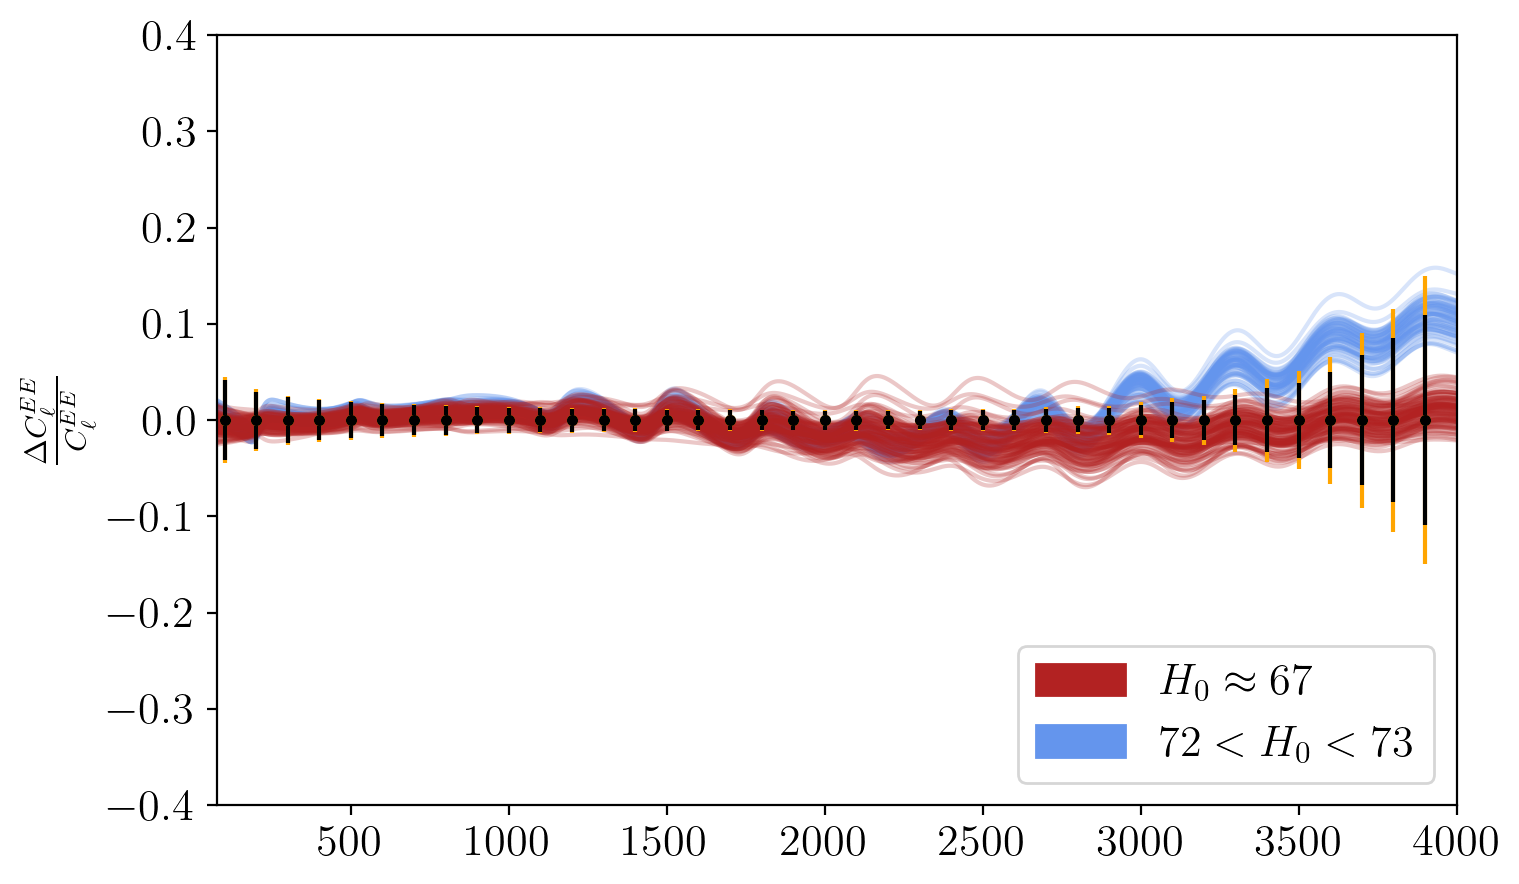

In [76]:
fig,ax = plt.subplots(figsize=(8,5))

ref_model=ee_fid

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ref_model, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")
   #ax.set_ylabel("$\Delta C_\ell^{EE}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ref_model, color=low_H0_color, alpha=0.25)

error_bar_3G_7yr = error_bar_3G*(6./7)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G_7yr[x_values-2]/ref_model[x_values-1]/10, fmt=".", color="orange")
ax.errorbar(x_values, y_values, yerr=error_bar_3G_combined[x_values-2]/ref_model[x_values-1]/10, fmt=".", color="black")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

#ax.set_ylim([-5e-8, 5e-8])
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([75, 4000])

## Fine grain bands

In [87]:
H0_values = np.arange(67.5, 73.5, 0.5)
print(H0_values)

band_indices = {}

for H in H0_values[:-1]:
    bounds = [H, H+0.5]
    H_band_indices = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>bounds[0], modrec["H0"]<bounds[1]))).flatten()
    band_indices[H] = H_band_indices
    print("In band [{}, {}]: {}".format(bounds[0], bounds[1], len(H_band_indices)))

[67.5 68.  68.5 69.  69.5 70.  70.5 71.  71.5 72.  72.5 73. ]
In band [67.5, 68.0]: 9640
In band [68.0, 68.5]: 11571
In band [68.5, 69.0]: 11373
In band [69.0, 69.5]: 9766
In band [69.5, 70.0]: 7155
In band [70.0, 70.5]: 4650
In band [70.5, 71.0]: 2505
In band [71.0, 71.5]: 981
In band [71.5, 72.0]: 346
In band [72.0, 72.5]: 60
In band [72.5, 73.0]: 4


In [88]:
900*2/60

30.0